In [5]:
import matplotlib.pyplot as plt
import os
import collections
import tqdm
import os.path
import tarfile
from itertools import islice
import operator
from os import listdir
import zipfile
import regex as reg
from collections import Counter, defaultdict

In [6]:
def take(n, iterable):
  "Return first n items of the iterable as a list"
  return list(islice(iterable, n))

# Task 4

Sort bills according to their size and take top 50 (largest) bills.


In [9]:
# open file
tar = tarfile.open('ustawy.tar.gz')
  
# extracting file
tar.extractall('/content/acts')
bills = [tarinfo.name for tarinfo in tar]  
bills[0]
tar.close()

In [10]:
acts_size = defaultdict()

for bill in bills:
  with open(f'/content/acts/{bill}') as f:
    fil = f.read()
    size = len(fil)
    acts_size[bill] = size

In [13]:
sorted_d = dict( sorted(acts_size.items(), key=operator.itemgetter(1),reverse=True))
largest_50 = take(50, sorted_d)
print(largest_50)

['2000_696.txt', '2001_627.txt', '1996_465.txt', '1997_555.txt', '2002_1689.txt', '2000_1186.txt', '1998_1118.txt', '1997_117.txt', '2001_1070.txt', '2001_1368.txt', '1997_714.txt', '2001_499.txt', '2000_991.txt', '2003_1750.txt', '2001_1545.txt', '2001_1229.txt', '2000_1268.txt', '1994_195.txt', '1997_926.txt', '2000_1104.txt', '2003_2277.txt', '1997_553.txt', '2004_2065.txt', '2004_1693.txt', '2004_880.txt', '2004_177.txt', '2003_423.txt', '1997_349.txt', '2000_1315.txt', '1999_930.txt', '1994_591.txt', '1996_110.txt', '1997_557.txt', '1999_95.txt', '2004_2533.txt', '2001_1381.txt', '2000_136.txt', '1996_460.txt', '2001_1438.txt', '1996_561.txt', '2001_1188.txt', '2001_475.txt', '2001_628.txt', '1998_602.txt', '2003_2256.txt', '2001_906.txt', '1996_496.txt', '2001_92.txt', '1997_153.txt', '2001_1444.txt']


# Task 5

Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence.


In [14]:
with zipfile.ZipFile('Wynik.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/lemmatized_acts')

lemmatized_bills = [f for f in listdir('/content/lemmatized_acts')]

In [15]:
lemmatized_tokens = defaultdict()

for bill in largest_50:
  with open(f'/content/lemmatized_acts/{bill}') as file:
    f = file.read()
    pattern = reg.findall(r'\<tok\>\n\s+.*\n.*',f)
    pattern = " ".join(pattern)
    patri = reg.findall(r'\<orth\>(\S+)\<',pattern)
    lemmatized_word = reg.findall(r'\<base\>(\S+)\<\/base\>', pattern)
    both_words = list(zip(patri, lemmatized_word))
    lemmatized_words = [word[1].capitalize() if word[0].istitle() else word[1] for word in both_words]

    lemmatized_tokens[bill] = lemmatized_words

In [16]:
def find_entity_names(lemmatized_bill: list) -> list:

    result = []
    pos = 0
    idx = 0
    # for idx, token in enumerate(lemmatized_bill):
    while idx < len(lemmatized_bill):
        idx += 1
        if idx >= 1 and idx < len(lemmatized_bill): # First token starts a sentence
            if lemmatized_bill[idx-1] != '.' and lemmatized_bill[idx][0].isupper():
                temp_ = [_ for _ in lemmatized_bill[idx:]]
                pos = 0
                candidates = ''
                try:
                    while temp_[pos][0].isupper():
                        candidates += f' {temp_[pos]}'
                        pos += 1
                except IndexError:
                    pass
                result.append(candidates[1:])
                idx += pos
    return result

find_entity_names(['Wczoraj', 'w', 'Kraków','mieć', 'miejsce', 'spotkanie', 'prezydenci', 'Polska', 'i', 'Stany', 'Zjednoczone'])

['Kraków', 'Polska', 'Stany Zjednoczone']

In [17]:
upper_words = defaultdict()

for bill in lemmatized_tokens.keys():
  words = find_entity_names(lemmatized_tokens[bill])
  upper_words[bill] = words

# Task 6

Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.


In [18]:
counts_global = defaultdict()

for bill in upper_words.keys():
  ctr = Counter(upper_words[bill])
  for word in ctr.keys():
    if word in counts_global.keys():
      counts_global[word] += ctr[word]
    else:
      counts_global[word] = ctr[word]



In [19]:
counts_global = dict( sorted(counts_global.items(), key=operator.itemgetter(1),reverse=True))
take(10, counts_global.items())

[('Nr', 3831),
 ('Art', 1959),
 ('Dzieje_(apostolskie)', 1063),
 ('Rzeczpospolita Polski', 679),
 ('Dziennik', 539),
 ('Kodeks', 510),
 ('Policja', 463),
 ('D', 451),
 ('Skarb Państwo', 397),
 ('Prawo', 303)]

# Task 7

Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model.

The task was done with the help of this repository:

https://github.com/CLARIN-PL/NlpRest2-Tutorials/blob/master/part3.ipynb

In [22]:
with zipfile.ZipFile('Wynik1.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ner_acts')

ner_bills = [f for f in listdir('/content/ner_acts')]

In [23]:
class Token:
    
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag
        
    def get_orth(self):
        return self.orth
    
    def get_base(self):
        return self.base
    
    def get_ctag(self):
        return self.ctag
        

class Annotation:
    
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()
        
    def get_category(self):
        return self.category
    
    def get_tokens(self):
        return self.tokens
    
    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens])

    def get_base(self):
        return " ".join([token.get_base() for token in self.tokens])
    
    def get_ctag(self):
        return " ".join([token.get_ctag() for token in self.tokens])
    
    def get_space(self):
        return " ".join(["True" for token in self.tokens])
    
    def get_lemma(self):
        return self.lemma
    
    def set_lemma(self, lemma):
        self.lemma = lemma

    def __str__(self):
        return "[%s] %s" % (self.get_category(), self.get_lemma())


In [24]:
import xml.etree.ElementTree as ET

def sentence_ner(sentence):
    channels = {}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):            
            index = int(channel.text)
            chan = channel.attrib["chan"]            
            if index > 0:                
                channels.setdefault(chan, {}) \
                        .setdefault(index, []) \
                        .append(t)
                
    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():            
            an = Annotation(ann_type, tokens)
            annotations.append(an)
    
    return annotations
                

def ccl_ner(ccl):
    tree = ET.parse(ccl)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations


In [37]:


coarse_grained_class_counter = collections.defaultdict(int)

for file in tqdm.tqdm([file for file in os.listdir('/content/ner_acts')]):
    annotations = ccl_ner(os.path.join('/content/ner_acts', file))
    for annotation in annotations:
      print(annotation)
      category = annotation.get_category()
      coarse_category = '_'.join(category.split('_')[:2])
      coarse_grained_class_counter[coarse_category] += 1


  2%|▏         | 1/50 [00:01<00:51,  1.05s/it]

[nam_pro_media_periodic] Dz . U .
[nam_pro_title_document] Kodeksu morskiego
[nam_loc_astronomical] Ziemi
[nam_eve_human] Kodeksu morskiego
[nam_org_institution] Marynarki Wojennej
[nam_pro_media_periodic] Straży Granicznej
[nam_loc_gpe_country] Polska
[nam_adj_country] polskiej
[nam_adj_country] polskiej
[nam_adj_country] polską
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_adj_country] polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_adj_country] polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_adj_country] polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_adj_country] polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczyposp

  4%|▍         | 2/50 [00:02<00:52,  1.09s/it]

[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Funduszu Ubezpieczeń Społecznych
[nam_org_institution] Zakładu Ubezpieczeń Społecznych
[nam_org_institution] Funduszu Rezerwy Demograficznej
[nam_org_institution] Zakład Ubezpieczeń Społecznych
[nam_org_institution] Sejmu
[nam_org_group_team] Kancelaria Senatu
[nam_org_institution] Komendzie Głównej Policji
[nam_org_institution] Służby Więziennej
[nam_org_institution] Urząd Ochrony Państwa
[nam_org_institution] Urzędu Ochrony Państwa
[nam_liv_person] Zakładowi
[nam_org_company] Zakład
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Urzędu Ochrony Państwa
[nam_org_institution] Służby Więziennej
[nam_liv_person] Straży Granicznej
[nam_org_organization] Państwowej Straży Pożarnej
[nam_org_organization] Organizacji Narodów Zjednoczonych
[nam_adj_country] polskim
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Polsce
[nam_pro_title_document] Pra

  6%|▌         | 3/50 [00:03<00:51,  1.10s/it]

[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Inspekcji Farmaceutycznej
[nam_org_institution] Dobrej Praktyki Wytwarzania
[nam_liv_person] Praktyką Dystrybucyjną
[nam_liv_person] Praktyką Laboratoryjną
[nam_org_institution] Dobrą Praktyką Kliniczną
[nam_org_institution] Dobrą Praktyką Wytwarzania
[nam_loc_gpe_city] Farmakopei Polskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Światową Organizację Zdrowia
[nam_pro_media_periodic] Dz . U .
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_organization] Unii Europejskiej
[nam_org_institution] Komisję Europejską
[nam_org_institution] Prezes Urzędu Rejestracji Produktów Leczniczych
[nam_org_group_team] Produktów Biobójczych
[nam_org_institution] Prezes Urzędu
[nam_org_institution] Prezesowi Urzędu
[nam_org_institution] Prezesa Urzędu
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Prezesowi Urzędu
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] C

  8%|▊         | 4/50 [00:04<00:52,  1.13s/it]

[nam_pro_media_periodic] Dz . U .
[nam_liv_person] S T A W A
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_pro_title_document] ustawy z dnia 28 września 1991 r . o lasach
[nam_pro_media_periodic] Dz . U .
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Służb Parków Narodowych
[nam_org_institution] Rady Ministrów
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Rada Ministrów
[nam_org_institution] Skarbu Państwa
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Skarbu Państwa
[nam_adj_country] łowieckich
[nam_pro_title_document] ustawy z dnia 28 listopada 1998 r . o finansach publicznych
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Górskiego Ochotniczego Pogotowia Ratunkowego
[nam_org_institution] Tatrzańskiego Ochotniczego Pogotowia Ratunkowego
[nam_pro_title_document] Kodeksu cywilnego
[nam_pro_media_periodic] Dz . U .
[nam_pr

 10%|█         | 5/50 [00:05<00:53,  1.20s/it]

[nam_pro_media_periodic] Dz . U .
[nam_org_institution] KODEKS CELNY
[nam_org_institution] PRZEPISY OGÓLNE
[nam_adj_country] polski
[nam_adj_country] polski
[nam_adj_country] polski
[nam_adj_country] polski
[nam_adj_country] polski
[nam_adj_country] polskiego
[nam_adj_country] polski
[nam_adj_country] polski
[nam_org_institution] Rada Ministrów
[nam_pro_media_periodic] Dz . U .
[nam_adj_country] polski
[nam_adj_country] polski
[nam_adj_country] polski
[nam_org_institution] Rada Ministrów
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_adj_country] polski
[nam_adj_country] polski
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Prezes Głównego Urzędu Ceł
[nam_org_institution] Światową Organizację Celną
[nam_org_institution] Systemu Oznaczania i Kodowania Towarów
[nam_org_institution] Światową Organizację Celną
[nam_org_institution] Nomenklatury Scalonej Unii Europejskiej
[nam_org_institution] Prezes Głównego Urzędu Ceł
[nam_adj_country] polski
[nam_loc_gpe_country] Rzeczy

 12%|█▏        | 6/50 [00:07<00:59,  1.35s/it]

[nam_org_institution] Prezydent Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Ministra Sprawiedliwości
[nam_org_institution] Ministra Obrony Narodowej
[nam_org_institution] Izbie Wojskowej Sądu Najwyższego
[nam_org_institution] Minister Obrony Narodowej
[nam_org_institution] Minister Sprawiedliwości
[nam_org_institution] Ministrem Obrony Narodowej
[nam_org_institution] Krajowej Rady Sądownictwa
[nam_org_institution] Minister Sprawiedliwości
[nam_org_institution] Ministrem Obrony Narodowej
[nam_org_institution] Pierwszego Prezesa Sądu Najwyższego lub Prezesa Naczelnego Sądu Administracyjnego
[nam_org_institution] Sądzie Najwyższym
[nam_org_institution] Ministrowi Sprawiedliwości
[nam_org_institution] Ministra Sprawiedliwości
[nam_org_institution] Minister Sprawiedliwości
[nam_org_institution] Minister Sprawiedliwości zawiadamia Prezydenta Rzeczypospolitej Polskiej , Krajową Radę Sądownictwa
[nam_org_institution] Ministra Obrony Narodowej

 14%|█▍        | 7/50 [00:08<00:51,  1.20s/it]

[nam_pro_media_periodic] Dz . U .
[nam_pro_title_document] ustawy o podatkach i opłatach lokalnych
[nam_pro_title_document] Ordynacja podatkowa
[nam_pro_title_document] ustawy o finansach publicznych
[nam_pro_title_document] ustawy o podatku dochodowym od osób prawnych
[nam_org_organization] Unii Europejskiej
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Europejskiego Funduszu Orientacji i Gwarancji dla Rolnictwa
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_institution] Unii Europejskiej
[nam_loc_gpe_country] Rzeczpospolita Polska
[nam_loc_gpe_country] Rzeczpospolita Polska
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczpospolita Polska
[nam_loc_gpe_country] Rzeczpospolita Polska
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Komitet do Spraw Dochodzeni

 16%|█▌        | 8/50 [00:09<00:46,  1.10s/it]

[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Inspekcji Weterynaryjnej
[nam_pro_title_document] ustawie z dnia 21 grudnia 1990 r . o zawodzie lekarza weterynarii i izbach lekarsko - weterynaryjnych
[nam_pro_media_periodic] Dz . U .
[nam_adj_country] polską
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Krajowej Rady Lekarsko - Weterynaryjnej
[nam_org_organization] Unii Europejskiej
[nam_org_institution] Inspekcji Weterynaryjnej
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Inspekcji Weterynaryjnej
[nam_org_institution] Inspekcji Weterynaryjnej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Europejskiej
[nam_org_institution] Inspekcji Weterynaryjnej
[nam_org_organization] Unii Europejskiej
[nam_org_organization] Unii Euro

 18%|█▊        | 9/50 [00:10<00:47,  1.16s/it]

[nam_org_institution] Urzędu Patentowego Rzeczypospolitej Polskiej
[nam_org_institution] Urzędem Patentowym
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczpospolita Polska
[nam_pro_title_document] Konwencję paryską
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Urzędem Patentowym
[nam_org_institution] Prezes Urzędu Patentowego
[nam_org_institution] Urząd Patentowy
[nam_org_institution] Urzędem Patentowym
[nam_org_institution] Urząd Patentowy
[nam_org_institution] Urzędzie Patentowym
[nam_org_institution] Urzędzie Patentowym
[nam_org_institution] Urzędu Patentowego
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Urzędzie Patentowym
[nam_loc_gpe_country] Polsce
[nam_org_institution] Urzędzie Patentowym
[nam_loc_gpe_country] Polsce
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Prezesa Urzędu Patentowego
[nam_org_institution] Dzienniku Urzędowym Rzeczypospolitej Polskiej "
[nam_pro_title] Monitor Polski
[nam

 20%|██        | 10/50 [00:11<00:50,  1.25s/it]

[nam_pro_media_periodic] Dz . U .
[nam_liv_person] S T A W A
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_org_institution] Sił Zbrojnych Rzeczypospolitej Polskiej
[nam_pro_title] Siłami Zbrojnymi
[nam_org_institution] Sił Zbrojnych
[nam_org_institution] Rada Ministrów
[nam_org_institution] Minister Obrony Narodowej
[nam_liv_person] Sił Zbrojnych
[nam_org_institution] Minister Obrony Narodowej
[nam_org_institution] Sił Zbrojnych
[nam_org_institution] Żandarmerii Wojskowej
[nam_org_institution] Minister Obrony Narodowej
[nam_liv_person] Sił Zbrojnych
[nam_org_institution] Minister Obrony Narodowej
[nam_liv_person] Sił Zbrojnych
[nam_liv_person] Sił Zbrojnych
[nam_pro_title_document] Prawo o ustroju sądów wojskowych
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Sił Zbrojnych
[nam_org_institution] Departamencie Sądów Wojskowych Ministerstwa Sprawiedliwości
[nam_pro_title_document] ustawy z dnia 21 listopada 1967 r . o powsze

 22%|██▏       | 11/50 [00:13<00:46,  1.20s/it]

[nam_pro_media_periodic] Dz . U .
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_pro_title_document] ustawy z dnia 14 grudnia 1994 r . o zatrudnieniu i przeciwdziałaniu bezrobociu
[nam_pro_media_periodic] Dz . U .
[nam_pro_media_periodic] Dz . U .
[nam_pro_title_document] ustawie z dnia 17 czerwca 1966 r . o uzdrowiskach i lecznictwie uzdrowiskowym
[nam_pro_media_periodic] Dz . U .
[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Światową Organizację Zdrowia
[nam_org_institution] Ministra Pracy i Polityki Socjalnej
[nam_org_institution] Dzienniku Urzędowym Rzeczypospolitej Polskiej "
[nam_org_institution] Prezesa Głównego Urzędu Statystycznego w Dzienniku Urzędowym Rzeczypospolitej Polskiej "
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_loc_gpe_country] Rzeczypospolitej Polskiej
[nam_pro_title] Monitor Polski
[nam_pro_title] Monitor Polski
[nam_pro_title_document] ustawie z dnia 30 sierpnia 1991 r . o zakładach opieki

 24%|██▍       | 12/50 [00:14<00:46,  1.23s/it]

[nam_pro_media_periodic] Dz . U .
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Trybunału Konstytucyjnego
[nam_org_institution] Minister Finansów
[nam_org_institution] Biuletynie Skarbowym Ministerstwa Finansów
[nam_org_institution] Rada Ministrów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Prezes Rady Ministrów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Minister Finansów
[nam_org_institution] Skarbowi Państwa
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Skarb Państwa
[nam_org_institution] Skarbu Państwa
[nam_org_institution] Ministe

 24%|██▍       | 12/50 [00:15<00:49,  1.31s/it]


KeyboardInterrupt: ignored

<BarContainer object of 9 artists>

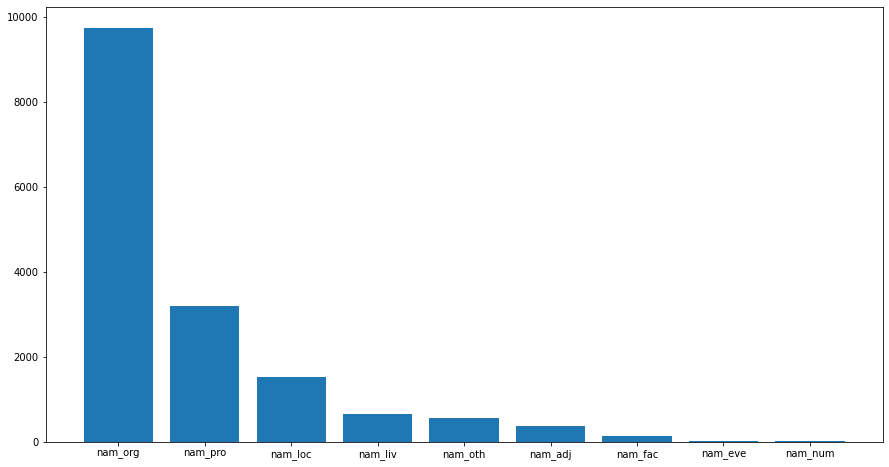

In [29]:
coarse_grained_class_counter = dict(sorted(coarse_grained_class_counter.items(), key=operator.itemgetter(1),reverse=True))
plt.figure(figsize=(15, 8))
plt.bar(coarse_grained_class_counter.keys(), coarse_grained_class_counter.values())

# Task 8

Display 10 most frequent Named Entities for each coarse-grained type.


In [31]:
coarse_grained_class_entity_counter = collections.defaultdict(lambda: collections.defaultdict(int))

for file in tqdm.tqdm([file for file in os.listdir('/content/ner_acts')]):
    annotations = ccl_ner(os.path.join('/content/ner_acts', file))
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        coarse_category = '_'.join(category.split('_')[:2])
        coarse_grained_class_entity_counter[coarse_category][entity] += 1


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


In [32]:
for category, entities in coarse_grained_class_entity_counter.items():
    print('-----------------------------------------------------------')
    for entity, count in list(sorted(entities.items(), key=lambda pair: -pair[1]))[:10]:
        print(f'| {category} | {str(count).ljust(4)} | {entity.ljust(38)} |')
print('-----------------------------------------------------------')


-----------------------------------------------------------
| nam_pro | 1534 | Dz . U .                               |
| nam_pro | 80   | Dz . Urz                               |
| nam_pro | 71   | Ordynacja podatkowa                    |
| nam_pro | 64   | Kodeksu karnego                        |
| nam_pro | 62   | Monitor Polski                         |
| nam_pro | 51   | Spraw Wewnętrznych                     |
| nam_pro | 35   | Kodeksu postępowania administracyjnego |
| nam_pro | 33   | Kodeksu postępowania karnego           |
| nam_pro | 32   | Kodeksu postępowania cywilnego         |
| nam_pro | 26   | Natura 2000                            |
-----------------------------------------------------------
| nam_loc | 812  | Rzeczypospolitej Polskiej              |
| nam_loc | 52   | Rzeczpospolita Polska                  |
| nam_loc | 51   | Polsce                                 |
| nam_loc | 39   | Rzeczpospolitą Polską                  |
| nam_loc | 32   | Warszawie            

# Task 10

Display 50 most frequent Named Entities including their count and fine-grained type.


In [34]:
fine_grained_class_entity_counter = collections.defaultdict(int)

for file in tqdm.tqdm([file for file in os.listdir('/content/ner_acts')]):
    annotations = ccl_ner(os.path.join('/content/ner_acts', file))
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        fine_grained_class_entity_counter[(entity, category)] += 1

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


In [35]:

sorted_fine_grained_class_entity_counter = sorted(
    fine_grained_class_entity_counter.items(),
    key=lambda pair: -pair[1]
)

print('-----------------------------------------------------------------------------------')
for entity, count in sorted_fine_grained_class_entity_counter[:50]:
    entity, category = entity
    print(f'| {str(count).ljust(4)} | {entity.ljust(48)}| {category.ljust(22)} |')
print('-----------------------------------------------------------------------------------')


-----------------------------------------------------------------------------------
| 1534 | Dz . U .                                        | nam_pro_media_periodic |
| 812  | Rzeczypospolitej Polskiej                       | nam_loc_gpe_country    |
| 295  | Skarbu Państwa                                  | nam_org_institution    |
| 293  | zł                                              | nam_oth_currency       |
| 290  | Unii Europejskiej                               | nam_org_organization   |
| 261  | Rada Ministrów                                  | nam_org_institution    |
| 233  | Minister Sprawiedliwości                        | nam_org_institution    |
| 213  | Prezes Rady Ministrów                           | nam_org_institution    |
| 205  | Państwowej Straży Pożarnej                      | nam_org_organization   |
| 162  | Minister Obrony Narodowej                       | nam_org_institution    |
| 152  | Minister Finansów                               | nam_org_instituti

# Task 11

Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color. (For demo application Streamlit might be useful for displaying NER results).


1. Obsługę Rady Nadzorczej (nam_org) i Zarządu (nam_loc) zapewnia biuro Narodowego Funduszu (nam_org).

2. Pierwszeństwo do uzyskania patentu, prawa ochronnego albo prawa z rejestracji oznacza się, na zasadach określonych w umowach międzynarodowych, według daty wystawienia wynalazku, wzoru użytkowego albo wzoru przemysłowego w Polsce (nam_loc) lub za granicą, na wystawie międzynarodowej oficjalnej lub oficjalnie uznanej, jeżeli zgłoszenie w Urzędzie Patentowym (nam_org) tego wynalazku, wzoru użytkowego albo wzoru przemysłowego dokonane zostanie w okresie 6 miesięcy od tej daty.

3. Prezes Rady Ministrów (nam_org) lub minister ogłosi w Dzienniku Ustaw Rzeczypospolitej Polskiej (nam_pro) jednolite teksty ustaw, o których mowa w art. 14, 15, 18, 19, 23, 27, 33, 36, 47, 50-53, 60, 61, 62, 64, 74-76, 78, 82, 86, 90, 91, 97, 107, 126, 137, 139 z uwzględnieniem zmian wynikających z przepisów ogłoszonych przed dniem wydania jednolitych tekstów ustaw.

4. Pierwszeństwo do uzyskania patentu, prawa ochronnego albo prawa z rejestracji przysługuje także, na zasadach określonych w ust. 1, w przypadku wystawienia wynalazku, wzoru użytkowego albo wzoru przemysłowego na innej niż określona w ust. 1 wystawie publicznej w Polsce (nam_loc), wskazanej przez Prezesa Urzędu Patentowego (nam_org) w formie obwieszczenia w Dzienniku Urzędowym Rzeczypospolitej Polskiej (nam_pro) "Monitor Polski" (nam_pro).

5. W przypadkach uzasadnionych potrzebą dokonywania odrębnych wpisów, w Urzędzie Patentowym (nam_org) prowadzone są pomocnicze rejestry praw udzielonych z mocą na terytorium Rzeczypospolitej Polskiej (nam_loc), zarejestrowanych w międzynarodowym organie na podstawie umowy międzynarodowej.





# Task 12

Answer the following questions:
1.  Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

NER performs significantly better.

The method based on capitalized words does not take into account inhabitants of countries, lands and continents, as well as any other capitalized expressions.

NER considers the names of currencies (euro, zloty) where a separate category (nam_oth) is intended for them, it is also dedicated to technology names. NER also detects numeric expressions (nam_num) or adjectives derived from proper names (num_adj), which are also not proper names.

2.  What are the drawbacks of the method based on capital letters?

It does not support the following cases:

* proper names containing words beginning with lowercase letters e.g., "Minister Zdrowia i Opieki Społecznej",
* naming units occurring at the beginning of a sentence,
* text written in capital letters (e.g., "USTA", "XXI"),

3.  What are the drawbacks of the method based on NER?

The results of the NER method look much better, but quite a few duplicates can be seen among them (such as Państwowa Komisja Wyborcza and Państwowej Komisji Wyborczej or Rzeczypospolitej Polskiej with Rzeczpospolita Polska). In the case of the naive method, tokenization and lemmatization were performed, which allowed to agree on the form of words at the start.

Additionally, the biggest drawback of this method was the time it took to complete.

4. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

The best results turned out to be for  nam_org (names of organizations - mainly proper names of offices and positions) and nam_pro (mainly proper names of documents and magazines). These categories contain quite long proper names characteristic of legal language. 

The worst results were achieved for nam_liv (names of living beings) - phrases such as: "kasa chorych", "Pan" (classified as the name of a god from Greek Mythology), "krajowy depozyt".
nam_eve (names of events) - of the 10 most common matches, most are not events. A particularly difficult case is "EURO," which was sometimes classified as the name of a currency, and sometimes as the name of a sports event - the algorithm was unable to correctly infer the meaning from the context.

5. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?

NER does not give us information about the canonical form of the naming unit. In the lemmatized form, we have "USA" and "stan zjednoczony." We could use a dictionary of synonyms to relate these forms.

6. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

* Automatic generation of book index
* Targetowanie artykułów czy reklam na podstawie wyszukiwanych fraz, przeglądanych stron czy pisanych wiadomości.

